In [1]:
# import tensorflow_decision_forests as tfdf

import os
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa
import math

# Check the version of TensorFlow Decision Forests
# print('Found TF-DF v' + tfdf.__version__)

In [2]:
dataset_df = pd.read_json("./data/all_ads.json")
dataset_df.head(5)

,category,fuel_cb,gearbox_cb,id,locality,manufacturer_cb,model_cb,price,tachometer,vehicle_age
0,Osobní,Nafta,Automatická,152780061,Středočeský kraj,BMW,Řada 3,1349000,26000,1
1,Osobní,Nafta,Manuální,152768137,Hlavní město Praha,BMW,Řada 3,455000,193107,5
2,Osobní,Nafta,None,152434055,Jihočeský kraj,BMW,Řada 3,1510000,12000,1
3,Osobní,Nafta,Automatická,152415752,Královéhradecký kraj,BMW,Řada 3,1228149,25400,1
4,Osobní,Hybridní,Automatická,152255217,Moravskoslezský kraj,BMW,Řada 3,1703000,24000,1


In [3]:
# Build the dataframe for train data
dataset_df = dataset_df.drop(["id", "category"], axis=1)

train_numerical = dataset_df.select_dtypes(exclude=["object"])
train_numerical.fillna(0, inplace=True)
train_categoric = dataset_df.select_dtypes(include=["object"])
train_categoric.fillna("NONE", inplace=True)
train = train_numerical.merge(train_categoric, left_index=True, right_index=True)


In [4]:
# from sklearn.ensemble import IsolationForest

# clf = IsolationForest(max_samples=100, random_state=42)
# clf.fit(train_numerical)
# y_noano = clf.predict(train_numerical)
# y_noano = pd.DataFrame(y_noano, columns=["Top"])
# y_noano[y_noano["Top"] == 1].index.values
# train_numerical = train_numerical.iloc[y_noano[y_noano["Top"] == 1].index.values]
# train_numerical.reset_index(drop=True, inplace=True)
# train_categoric = train_categoric.iloc[y_noano[y_noano["Top"] == 1].index.values]
# train_categoric.reset_index(drop=True, inplace=True)
# train = train.iloc[y_noano[y_noano["Top"] == 1].index.values]
# train.reset_index(drop=True, inplace=True)


In [5]:
train.head()

,price,tachometer,vehicle_age,fuel_cb,gearbox_cb,locality,manufacturer_cb,model_cb
0,1349000,26000,1,Nafta,Automatická,Středočeský kraj,BMW,Řada 3
1,455000,193107,5,Nafta,Manuální,Hlavní město Praha,BMW,Řada 3
2,1510000,12000,1,Nafta,NONE,Jihočeský kraj,BMW,Řada 3
3,1228149,25400,1,Nafta,Automatická,Královéhradecký kraj,BMW,Řada 3
4,1703000,24000,1,Hybridní,Automatická,Moravskoslezský kraj,BMW,Řada 3


In [6]:
from sklearn.preprocessing import MinMaxScaler

col_train_num = list(train_numerical.columns)
col_train_num_bis = list(train_numerical.columns)
col_train_cat = list(train_categoric.columns)
col_train_num_bis.remove("price")
mat_train = np.matrix(train_numerical)
mat_new = np.matrix(train_numerical.drop("price", axis=1))
mat_y = np.array(train.price)
prepro_y = MinMaxScaler()
prepro_y.fit(mat_y.reshape(mat_y.size, 1))
prepro = MinMaxScaler()
prepro.fit(mat_train)
prepro_test = MinMaxScaler()
prepro_test.fit(mat_new)
train_num_scale = pd.DataFrame(prepro.transform(mat_train), columns=col_train_num)
train[col_train_num] = pd.DataFrame(prepro.transform(mat_train), columns=col_train_num)


ValueError: cannot reshape array of size 78319 into shape (62112,1)

In [8]:
mat_y.size

78319

In [ ]:
from sklearn.model_selection import train_test_split

COLUMNS = col_train_num
FEATURES = col_train_num_bis
LABEL = "price"
FEATURES_CAT = col_train_cat

engineered_features = [tf.feature_column.numeric_column(key, shape=()) for key in FEATURES]

for categorical_feature in FEATURES_CAT:
    sparse_column = tf.feature_column.categorical_column_with_hash_bucket(categorical_feature, hash_bucket_size=5000)

    engineered_features.append(
        tf.feature_column.embedding_column(
            sparse_column, dimension=16, combiner="sqrtn"
        )
    )


In [ ]:
# Build the training set and the prediction set
training_set = train[FEATURES + FEATURES_CAT]
prediction_set = train.price
# Split the train and prediction sets into test train sets
x_train, x_test, y_train, y_test = train_test_split(
    training_set[FEATURES + FEATURES_CAT],
    prediction_set,
    test_size=0.2,
    random_state=42,
)
y_train = pd.DataFrame(y_train, columns=[LABEL])
training_set = pd.DataFrame(x_train, columns=FEATURES + FEATURES_CAT).merge(
    y_train, left_index=True, right_index=True
)
y_test = pd.DataFrame(y_test, columns=[LABEL])
testing_set = pd.DataFrame(x_test, columns=FEATURES + FEATURES_CAT).merge(
    y_test, left_index=True, right_index=True
)


In [ ]:
training_set[FEATURES_CAT] = training_set[FEATURES_CAT].applymap(str)
testing_set[FEATURES_CAT] = testing_set[FEATURES_CAT].applymap(str)


def input_fn_new(data_set, training=True):
    continuous_cols = {k: tf.constant(data_set[k].values) for k in FEATURES}

    categorical_cols = {
        k: tf.SparseTensor(
            indices=[[i, 0] for i in range(data_set[k].size)],
            values=data_set[k].values,
            dense_shape=[data_set[k].size, 1],
        )
        for k in FEATURES_CAT
    }
    # Combines the dictionaries of the categorical and continuous features
    feature_cols = dict(list(continuous_cols.items()) + list(categorical_cols.items()))

    if training == True:
        # Converts the label column into a constant Tensor.
        label = tf.constant(data_set[LABEL].values)
        # Outputs the feature columns and labels
        return feature_cols, label

    return feature_cols


# Builds the Model Framework
regressor = tf.estimator.DNNRegressor(
    feature_columns=engineered_features,
    activation_fn=tf.nn.relu,
    hidden_units=[125, 25],
)
categorical_cols = {
    k: tf.SparseTensor(
        indices=[[i, 0] for i in range(training_set[k].size)],
        values=training_set[k].values,
        dense_shape=[training_set[k].size, 1],
    )
    for k in FEATURES_CAT
}


INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/8c/dvncxl8n0733h0fz370kj7j80000gp/T/tmp1g5s7_rf', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [ ]:
regressor.train(input_fn=lambda: input_fn_new(training_set), steps=5000)


Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
INFO:tensorflow:Calling model_fn.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.


2022-09-26 03:56:33.881563: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled
2022-09-26 03:56:33.885970: W tensorflow/core/common_runtime/forward_type_inference.cc:332] Type inference failed. This indicates an invalid graph that escaped type checking. Error message: INVALID_ARGUMENT: expected compatible input types, but input 1:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_INT64
    }
  }
}
 is neither a subtype nor a supertype of the combined inputs preceding it:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_INT32
    }
  }
}

	while inferring type of node 'dnn/zero_fraction/cond/output/_18'
2022-09-26 03:56:33.912166: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...
INFO:tensorflow:Saving checkpoints for 0 into /var/folders/8c/dvncxl8n0733h0fz370kj7j80000gp/T/tmp1g5s7_rf/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...
INFO:tensorflow:loss = 0.05329557, step = 0
INFO:tensorflow:global_step/sec: 24.9995
INFO:tensorflow:loss = 0.045270126, step = 100 (4.000 sec)
INFO:tensorflow:global_step/sec: 32.0363
INFO:tensorflow:loss = 0.039469488, step = 200 (3.121 sec)
INFO:tensorflow:global_step/sec: 31.786
INFO:tensorflow:loss = 0.035015836, step = 300 (3.146 sec)
INFO:tensorflow:global_step/sec: 31.6759
INFO:tensorflow:loss = 0.031522337, step = 400 (3.157 sec)
INFO:tensorflow:global_step/sec: 31.5599
INFO:tensorflow:loss = 0.02875005, step = 500 (3.169 sec)
INFO:tensorflow:global_step/sec: 31.8072
INFO:tensorflow:loss = 0.026540034, step = 600 (3.144 sec)
INFO:tensorflow:global_step/sec: 31.8057
INFO:

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2022-09-26T11:49:25
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/8c/dvncxl8n0733h0fz370kj7j80000gp/T/tmp1g5s7_rf/model.ckpt-20000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Inference Time : 0.46414s
INFO:tensorflow:Finished evaluation at 2022-09-26-11:49:25
INFO:tensorflow:Saving dict for global step 20000: average_loss = 0.007126891, global_step = 20000, label/mean = 0.26825908, loss = 0.007126891, prediction/mean = 0.26844895
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 20000: /var/folders/8c/dvncxl8n0733h0fz370kj7j80000gp/T/tmp1g5s7_rf/model.ckpt-20000
Final Loss on the testing set: 0.007127
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2022-09-26T11:49:2

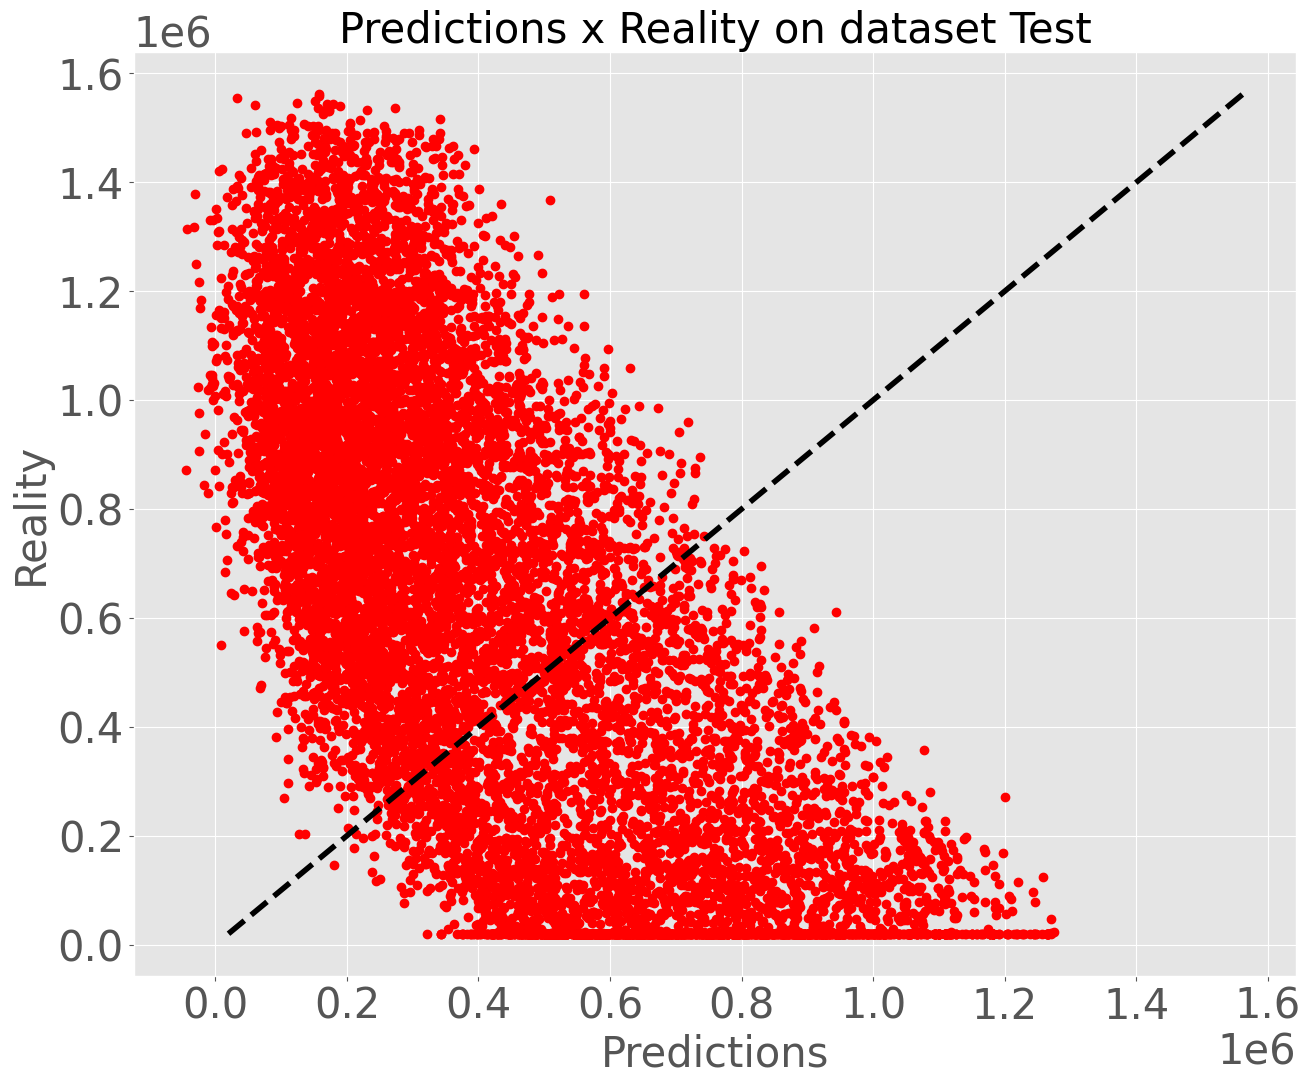

In [ ]:
import matplotlib.pyplot as plt
import matplotlib

ev = regressor.evaluate(
    input_fn=lambda: input_fn_new(testing_set, training=True), steps=1
)
loss_score = ev["loss"]
print("Final Loss on the testing set: {0:f}".format(loss_score))
import matplotlib.pyplot as plt
import matplotlib
import itertools

ev = regressor.evaluate(
    input_fn=lambda: input_fn_new(testing_set, training=True), steps=1
)
loss_score = ev["loss"]
print("Final Loss on the testing set: {0:f}".format(loss_score))

reality = pd.DataFrame(
    prepro.inverse_transform(testing_set.select_dtypes(exclude=["object"])),
    columns=[COLUMNS],
).price


y = regressor.predict(input_fn=lambda: input_fn_new(testing_set))
predictions_all = list(itertools.islice(y, testing_set.shape[0]))
predictions = [prediction["predictions"] for prediction in predictions_all]

predictions = pd.DataFrame(
    prepro_y.inverse_transform(np.array(predictions).astype(float).reshape(prepro_y.size, 1))
)

reality.to_json('res-reality.json')
predictions.to_json('res-predictions.json')

matplotlib.rc("xtick", labelsize=30)
matplotlib.rc("ytick", labelsize=30)
fig, ax = plt.subplots(figsize=(15, 12))
# plt.style.use("ggplot")
plt.plot(predictions.values, reality.values, "ro")
plt.xlabel("Predictions", fontsize=30)
plt.ylabel("Reality", fontsize=30)
plt.title("Predictions x Reality on dataset Test", fontsize=30)
ax.plot([reality.min(), reality.max()], [reality.min(), reality.max()], "k--", lw=4)
plt.show()
